NLP Dataset: IMDB-50K Movie Review dataset comprising of 50K movie reviews. Deep neural network on the IMDB-50K dataset.


## 1. Import Libraries/Dataset

In [35]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
import pandas as pd 
import seaborn as sns

In [36]:
# helper functions
def plot_learning_progress_loss(history):
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training','Validation'],loc='upper right')
    plt.show()
def plot_learning_progress_accuracy(history):
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy vs epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training','Validation'],loc='upper left')
    plt.show()   
def display_model_performance(model,x_test,y_test,display_labels):
    y_prob=model.predict(X_test)
    y_pred=np.round(y_prob)
    cm=tf.math.confusion_matrix(y_test,y_pred)
    print(cm)
    cm_n = cm.numpy()
    cm_n_norm = cm_n.astype('float') / cm_n.sum(axis=1)[:, np.newaxis]
    plt.rcParams["figure.figsize"] = (7,7)
    ConfusionMatrixDisplay(cm_n_norm,display_labels=display_labels).plot()  
    print('\nClassification Report\n')
    c_r=classification_report(y_test, y_pred, target_names=display_labels)
    print(c_r) 

In [37]:
# Is GPU Available?
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [38]:
# Get imdb data
imdb = tf.keras.datasets.imdb
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=10000)
imdb_labels= ['Negative','Positive']

## 2. Data Visualization

In [39]:
def decode_review(imdb, x_train, index):
  # Let's quickly decode a review

  # step 1: load the dictionary mappings from word to integer index
  word_index = imdb.get_word_index()

  # step 2: reverse word index to map integer indexes to their respective words
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

  # Step 3: decode the review, mapping integer indices to words
  #
  # indices are off by 3 because 0, 1, and 2 are reserverd indices for "padding", "Start of sequence" and "unknown"
  decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in x_train[index]])

  return decoded_review

In [47]:
# print review function
def print_review(no_of_record_to_print):
  unique_classes= np.unique(y_train) # Get unique output class
  for output_class in unique_classes:
    count=0
    print(f'\n\n{imdb_labels[output_class]} :\n')
    for idx, review in enumerate(y_train): 
      if review == output_class:    # is required output class
        print(f'\n{decode_review(imdb,x_train,idx)}') # print decoded review 
        count= count+ 1
      if count == no_of_record_to_print: #stop if no of required record print 
        break

In [48]:
#print two review record of each class
print_review(2)



Negative :


? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then

? this has to be one of the worst films of

1    12500
0    12500
dtype: int64


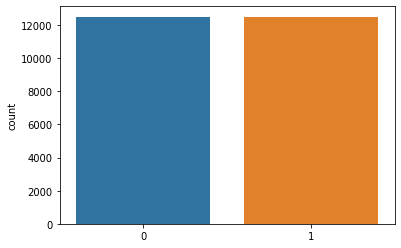

In [8]:
#Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment.
print(pd.value_counts(y_train))
sns.countplot(x=y_train)

In [9]:
#Print the shapes of train and test data.
print(f'x_train.shape: \t {x_train.shape}')
print(f'x_test.shape: \t {x_test.shape}')
print(f'y_train.shape: \t {y_train.shape}')
print(f'y_test.shape: \t {y_test.shape}')

x_train.shape: 	 (25000,)
x_test.shape: 	 (25000,)
y_train.shape: 	 (25000,)
y_test.shape: 	 (25000,)


## 3. Data Preprocessing

Prepare the data in required vectorized format

In [10]:
def vectorize_sequences(sequences, dimension=10000):
    #print(sequences)
    results = np.zeros((len(sequences), dimension))    # Creates an all zero matrix of shape (len(sequences),10K)
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1                        # Sets specific indices of results[i] to 1s
    return results


In [11]:
# Vectorize training Data
X_train = vectorize_sequences(x_train)

# Vectorize testing Data
X_test = vectorize_sequences(x_test)

In [12]:
X_train.shape

(25000, 10000)

In [13]:
X_test.shape

(25000, 10000)

# **Model#1**

## 4. Model Building

* We tried various number of layers and various neurons in each layer. We found that beyond 4 hidden layers and above 10 neurons in each layer accuracy is not improving any further significantly.
* We have added L2 regularization to avoid overfitting.
* Added one dropout layer on 2nd hidden layer. We tried applying dropout at various layers. We got almost similar validation accuracy by positioning dropout at different layers. When we applied dropout dropout on layer 2, we got good accuracies for both training and validation data set.
* ReLu is used as activation function for all hidden layers, since ReLu performs better then traditional activation functions such as sigmoid. For final layer sigmoid is used as activation function since we want categorize into 2 classes.

In [14]:
def get_regularized_model1(wd,rate):
    model=tf.keras.models.Sequential([tf.keras.layers.Dense(5,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal', activation='relu',input_shape=(10000,)),
                                  tf.keras.layers.Dense(10,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dropout(rate),  
                                  tf.keras.layers.Dense(10,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dense(10,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dense(1,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='sigmoid')])
    return model

In [15]:
model1 = get_regularized_model1(0.02,0.5)

In [16]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 50005     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 50,296
Trainable params: 50,296
Non-trainable params: 0
____________________________________________________

## 5. Model Compilation

### Loss function and optimizer
* We have selected BinaryCrossentropy as loss function since we are dealing with 2 classes.
* We have used Adam optimizer with learning rate=0.0001. Adam optimizer also uses beta_1=0.9 (exponential decay rate for the 1st moment estimates), beta_2=0.999 (exponential decay rate for the 2nd moment estimates).
We started with highr learning rates (0.001) and kept on lowering it and came to a conclusion that 0.0001 gives optimal accuracy without compromising on time taken to converge. 
* Accuracy is used as metric

In [17]:
model1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## 6. Model Training

* we have used 1024 batch size and early stopping with 100 epochs as limit

In [18]:
start_time = time.time()
history1 = model1.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=1024,
                   validation_data=(X_test, y_test),
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=0)])
end_time = time.time()

Epoch 1/100
25/25 [==============================] - 2s 81ms/step - loss: 2.0835 - accuracy: 0.5144 - val_loss: 2.0555 - val_accuracy: 0.5264
Epoch 2/100
25/25 [==============================] - 1s 42ms/step - loss: 2.0318 - accuracy: 0.5618 - val_loss: 2.0093 - val_accuracy: 0.5696
Epoch 3/100
25/25 [==============================] - 1s 41ms/step - loss: 1.9853 - accuracy: 0.5766 - val_loss: 1.9677 - val_accuracy: 0.5910
Epoch 4/100
25/25 [==============================] - 1s 40ms/step - loss: 1.9427 - accuracy: 0.6166 - val_loss: 1.9316 - val_accuracy: 0.6334
Epoch 5/100
25/25 [==============================] - 1s 40ms/step - loss: 1.9046 - accuracy: 0.6560 - val_loss: 1.9000 - val_accuracy: 0.6560
Epoch 6/100
25/25 [==============================] - 1s 40ms/step - loss: 1.8717 - accuracy: 0.6774 - val_loss: 1.8712 - val_accuracy: 0.6860
Epoch 7/100
25/25 [==============================] - 1s 41ms/step - loss: 1.8403 - accuracy: 0.7014 - val_loss: 1.8435 - val_accuracy: 0.6879
Epoch 

## 7. Model Evaluation

### Model performance, Confusion matrix and classification report

* Model performance: we have plotted training and validation loss and accuracy vs epochs
* Time taken to train model has been printed.
* Confusion matrix: We have give confusion matrix with counts (Vertical axis index stands for actual classes. Horizontal axis index stands for predicted classes.) as well as normalized confusion matrix with color coding
* Classification report is also provided which gives classwise performance


Easy reference to understand classification report:
* Precision: How much % of identified class  are correct (TP/(TP+FP))
* Recall:How much % of a class are correctly identified (TP/(All positive = TP+FN))
* f1-score: Harmonic mean between precision and recall
* support: Number of occurances of a given class

### Class performance 

Both positive and negative review are classes are having similar performance. In model#1 there is 1% difference in both recall and precision. F1 score of both classes are same across all models. This is possibly because IMDB-50K is a balanced dataset.

782/782 [==============================] - 2s 3ms/step - loss: 1.0373 - accuracy: 0.8824
Accuracy : 0.8824399709701538
Loss     : 1.0372978448867798


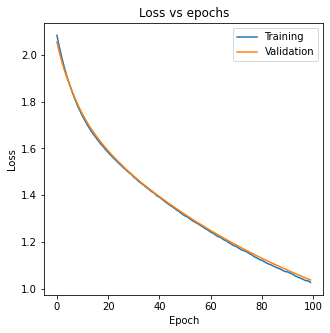

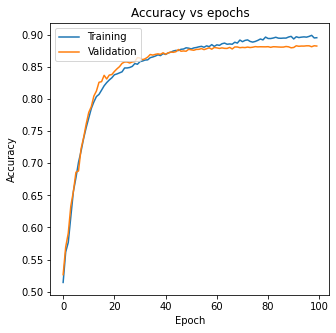

Time taken to train: 108.28734302520752 seconds


In [19]:
loss, accuracy = model1.evaluate(X_test,y_test)
print(f"Accuracy : {accuracy}")
print(f"Loss     : {loss}")
plot_learning_progress_loss(history1)
plot_learning_progress_accuracy(history1)
print("Time taken to train: %s seconds" % (end_time - start_time))

tf.Tensor(
[[11165  1335]
 [ 1604 10896]], shape=(2, 2), dtype=int32)

Classification Report

              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88     12500
    Positive       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



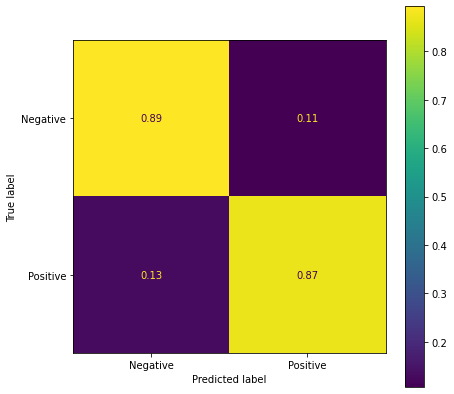

In [20]:
display_model_performance(model1,X_test,y_test,display_labels=imdb_labels)

## 8. Hyperparameter Tuning

# **Model#2**
## Changed number of hidden layers and hidden units in each layer


We experimented with various number of layers and hidden units per layer. We found that after increasing number of hidden layers to 5 andnumber of units each hidden layer to 30, we could further increase training accuracy but validation accuracy did not improve much. We feel that if we experiment further with regularization parameters we can try to increase validation accuracy further. We could not do further tuning due to lack of time.

In [21]:
def get_regularized_model2(wd,rate):
    model=tf.keras.models.Sequential([tf.keras.layers.Dense(30,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal', activation='relu',input_shape=(10000,)),
                                  tf.keras.layers.Dense(30,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dropout(rate),  
                                  tf.keras.layers.Dense(30,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dense(30,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'),                                  
                                  tf.keras.layers.Dense(30,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='relu'), 
                                  tf.keras.layers.Dense(1,kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal',activation='sigmoid')])
    return model

In [22]:
model2 = get_regularized_model2(0.02,0.5)

In [23]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                300030    
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [24]:
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
start_time = time.time()

In [25]:
history2 = model2.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=1024,
                   validation_data=(X_test, y_test),
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=0)])
end_time = time.time()

Epoch 1/100
25/25 [==============================] - 2s 71ms/step - loss: 6.4330 - accuracy: 0.5145 - val_loss: 6.2422 - val_accuracy: 0.5538
Epoch 2/100
25/25 [==============================] - 1s 41ms/step - loss: 6.0955 - accuracy: 0.5511 - val_loss: 5.9376 - val_accuracy: 0.6079
Epoch 3/100
25/25 [==============================] - 1s 41ms/step - loss: 5.8174 - accuracy: 0.5941 - val_loss: 5.6793 - val_accuracy: 0.6824
Epoch 4/100
25/25 [==============================] - 1s 41ms/step - loss: 5.5823 - accuracy: 0.6565 - val_loss: 5.4574 - val_accuracy: 0.7544
Epoch 5/100
25/25 [==============================] - 1s 42ms/step - loss: 5.3820 - accuracy: 0.7027 - val_loss: 5.2664 - val_accuracy: 0.7976
Epoch 6/100
25/25 [==============================] - 1s 42ms/step - loss: 5.2086 - accuracy: 0.7429 - val_loss: 5.1019 - val_accuracy: 0.8142
Epoch 7/100
25/25 [==============================] - 1s 41ms/step - loss: 5.0598 - accuracy: 0.7642 - val_loss: 4.9617 - val_accuracy: 0.8198
Epoch 

782/782 [==============================] - 3s 3ms/step - loss: 1.4346 - accuracy: 0.8832
Accuracy : 0.8832399845123291
Loss     : 1.4345723390579224


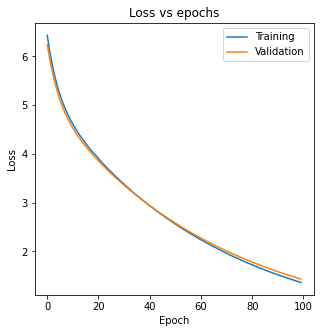

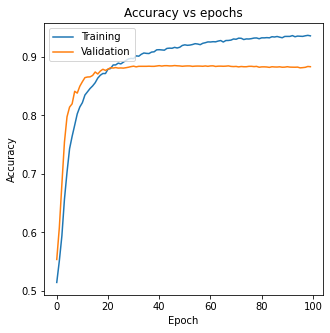

Time taken to train: 107.73941111564636 seconds


In [26]:
loss, accuracy = model2.evaluate(X_test,y_test)
print(f"Accuracy : {accuracy}")
print(f"Loss     : {loss}")
plot_learning_progress_loss(history2)
plot_learning_progress_accuracy(history2)
print("Time taken to train: %s seconds" % (end_time - start_time))	

tf.Tensor(
[[11042  1458]
 [ 1461 11039]], shape=(2, 2), dtype=int32)

Classification Report

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



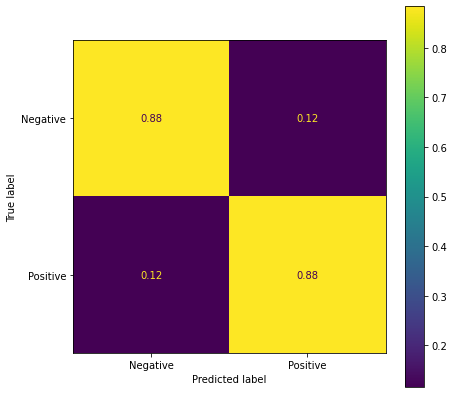

In [27]:
display_model_performance(model2,X_test,y_test,display_labels=imdb_labels)

# Model#3
## Trained model without regularization

Below we have trained model without regularization. We observed that training accuracy could go as high as 95% and was increasing even further. However validation accuracy got stuck at 88%. There is clearly overfitting happening here. **bold text**

In [28]:
def get_regularized_model3(wd,rate):
    model=tf.keras.models.Sequential([tf.keras.layers.Dense(5,kernel_initializer='he_normal', activation='relu',input_shape=(10000,)),
                                  tf.keras.layers.Dense(10,kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dense(10,kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dense(10,kernel_initializer='he_normal',activation='relu'),
                                  tf.keras.layers.Dense(1,kernel_initializer='he_normal',activation='sigmoid')])
    return model

In [29]:
model3 = get_regularized_model3(0.02,0.5)

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 5)                 50005     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 50,296
Trainable params: 50,296
Non-trainable params: 0
_________________________________________________________________


In [31]:
model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
start_time = time.time()

In [32]:
history3 = model3.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=1024,
                   validation_data=(X_test, y_test),
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=0)])
end_time = time.time()

Epoch 1/100
25/25 [==============================] - 2s 64ms/step - loss: 0.6933 - accuracy: 0.5028 - val_loss: 0.6925 - val_accuracy: 0.5222
Epoch 2/100
25/25 [==============================] - 1s 40ms/step - loss: 0.6901 - accuracy: 0.5588 - val_loss: 0.6889 - val_accuracy: 0.5635
Epoch 3/100
25/25 [==============================] - 1s 40ms/step - loss: 0.6811 - accuracy: 0.5915 - val_loss: 0.6740 - val_accuracy: 0.6242
Epoch 4/100
25/25 [==============================] - 1s 41ms/step - loss: 0.6593 - accuracy: 0.6876 - val_loss: 0.6516 - val_accuracy: 0.7137
Epoch 5/100
25/25 [==============================] - 1s 40ms/step - loss: 0.6329 - accuracy: 0.7473 - val_loss: 0.6275 - val_accuracy: 0.7635
Epoch 6/100
25/25 [==============================] - 1s 40ms/step - loss: 0.6040 - accuracy: 0.7910 - val_loss: 0.6014 - val_accuracy: 0.7818
Epoch 7/100
25/25 [==============================] - 1s 40ms/step - loss: 0.5729 - accuracy: 0.8216 - val_loss: 0.5739 - val_accuracy: 0.8008
Epoch 

782/782 [==============================] - 3s 3ms/step - loss: 0.2931 - accuracy: 0.8835
Accuracy : 0.8834800124168396
Loss     : 0.29314881563186646


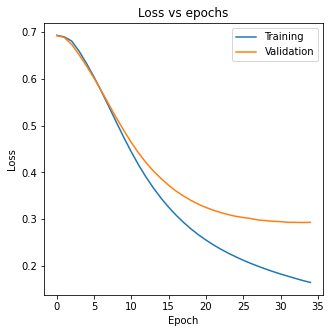

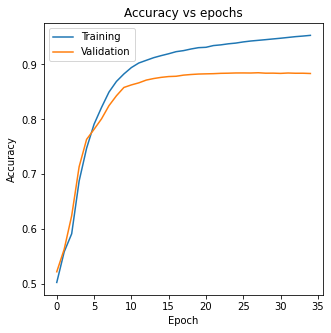

Time taken to train: 38.15799140930176 seconds


In [33]:
loss, accuracy = model3.evaluate(X_test,y_test)
print(f"Accuracy : {accuracy}")
print(f"Loss     : {loss}")
plot_learning_progress_loss(history3)
plot_learning_progress_accuracy(history3)
print("Time taken to train: %s seconds" % (end_time - start_time))	

tf.Tensor(
[[11138  1362]
 [ 1551 10949]], shape=(2, 2), dtype=int32)

Classification Report

              precision    recall  f1-score   support

    Negative       0.88      0.89      0.88     12500
    Positive       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



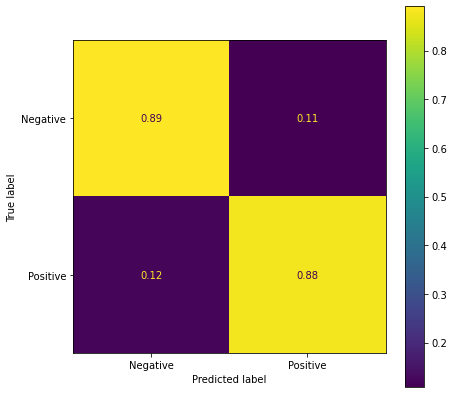

In [34]:
display_model_performance(model3,X_test,y_test,display_labels=imdb_labels)

## 9. Comparison of models

### Between model#1 and model#2
Model#1 is lower complexity model compared to model#2 (in terms number of hidden layers and # of units per hidden layer). Both of them achieved similar accuracy. However model#2 was overfitting and had further scope for fine tuning regularization parameters.


### Between model#1 and model#3 
Model#3 did not have any regularization and was clearly overfitting. The training accuracy could go as high as 94% however validation accuracy could not exceed 88%. Compared to this model% was not overfitting with both train and validation accuracy graphs close to each other.

### Comparison with state of art
Using recent advance learning technique, 97.4 accuracy has been achieved using "NB-weighted-BON + dv-cosine" model. A paper was pubished with title - "Sentiment Classification Using Document Embeddings Trained with Cosine Similarity"
(Source: https://paperswithcode.com/paper/sentiment-classification-using-document)
With neural network architecture, Graph Star Net for Generalized Multi-Task Learning got 96% accuracy. (Source: https://paperswithcode.com/paper/graph-star-net-for-generalized-multi-task-1)

-----------------------------------------------------------------------------------------------------------------------------The End---------------------------------------------------------------------------------------------